In [1]:
import numpy as np
import torch
from src import kernel_flow, datagen
import tqdm

## Regular Henon

### 1 step

In [32]:
# generate dataset
Data = datagen.Henon(T=200, dt=0.1,N_sims=1,a=1.4,b=0.3)[0]
#train test split
observed_data= Data
train_data = Data[:600,:].T
test_data = Data[600:,:].T
#times
Times = np.linspace(1,2000-1,2000-1)

# Some constants
nparameters=24
delay = 5
regu_lambda = 0.00001

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = datagen.prepare_data_fast(train_data,delay,normalize)
X_test, Y_test = datagen.prepare_data_fast(test_data,delay,normalize)

model= kernel_flow.KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 2, metric = "rho_ratio", batch_size = 100)
model, _ = kernel_flow.train_kernel(X_train, Y_train, model, lr = 0.1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 38.11it/s]


In [33]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)

horizon = 3

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = False)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()

print(f"MSE On test : {mse_pred:.4f}")

MSE On test : 0.0000


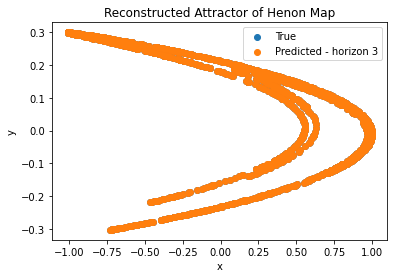

In [34]:
import matplotlib.pyplot as plt
plt.scatter(Y_test[:,0],Y_test[:,1], label = "True")
plt.scatter(Y_pred[:,0].detach(),Y_pred[:,1].detach(), label = f"Predicted - horizon {horizon}")
plt.title("Reconstructed Attractor of Henon Map")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

### n steps interval

In [30]:
n = 3

# generate dataset
Data = datagen.Henon(T=200, dt=0.1,N_sims=1,a=1.4,b=0.3)[0]
#train test split
observed_data= Data[0::n]
train_data = observed_data[:600,:].T
test_data = observed_data[600:,:].T
#times
Times = np.linspace(1,2000-1,2000-1)

# Some constants
nparameters=24
delay = 1
regu_lambda = 0.00001

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = datagen.prepare_data_fast(train_data,delay,normalize)
X_test, Y_test = datagen.prepare_data_fast(test_data,delay,normalize)

model = kernel_flow.KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 2, metric = "rho_ratio", batch_size = 100)

model = kernel_flow.train_kernel(X_train, Y_train, model, lr = 0.1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 77.18it/s]


In [31]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)

horizon = 3

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = False)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()

print(f"MSE On test : {mse_pred:.4f}")

MSE On test : 0.0054


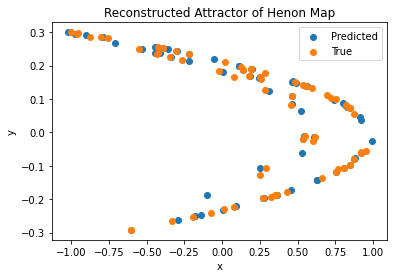

In [32]:
import matplotlib.pyplot as plt
plt.scatter(Y_pred[:,0].detach(),Y_pred[:,1].detach(), label = "Predicted")
plt.scatter(Y_test[:,0],Y_test[:,1], label = "True")
plt.title("Reconstructed Attractor of Henon Map")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

# Henon Map with irregular sampling

## Data Generation

In [32]:
max_delay = 3
N_points = 1000
train_n = 600
burnin = 200
dt = 0.1

delays = np.random.randint(max_delay,size=N_points-1)+1
indices = np.concatenate((np.zeros(1),np.cumsum(delays))).astype(int)
delays = np.concatenate((delays,np.zeros(1))).astype(int)

max_idx = indices[-1]
T = np.ceil(max_idx*dt)
# generate dataset
Data = datagen.Henon(T=T+burnin*dt, dt=dt,N_sims=1,a=1.4,b=0.3)[0][burnin:]

observed_data = Data[indices]

train_data = observed_data[:train_n,:].T
test_data = observed_data[train_n:,:].T

delays_train = delays[:train_n]
delays_test = delays[train_n:]

## Classical Kernel Flow

In [36]:
# Some constants
nparameters=24
delay = 1
regu_lambda = 0.00001
lr = 0.1

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = datagen.prepare_data_fast(train_data,delay,normalize)
X_test, Y_test = datagen.prepare_data_fast(test_data,delay,normalize)

model = kernel_flow.KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 2, metric = "rho_ratio", batch_size = 100)

model, rho_list = kernel_flow.train_kernel(X_train, Y_train, model, lr = lr, epochs = 1000)

0it [00:00, ?it/s]


In [39]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)

horizon = 1

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = False)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()

print(f"MSE On test : {mse_pred:.4f}")

MSE On test : 1556725.3750


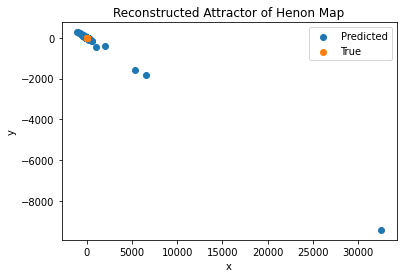

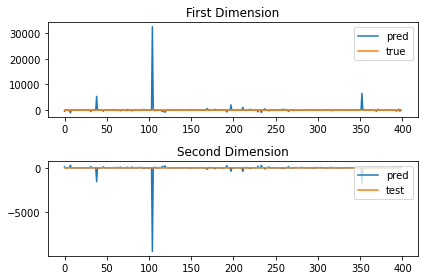

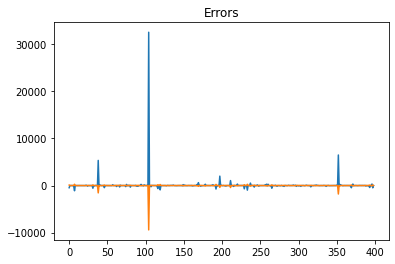

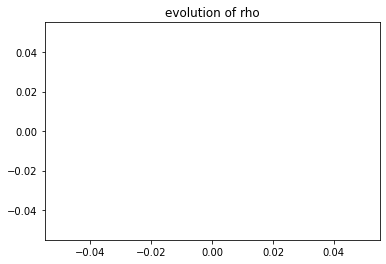

In [40]:
import matplotlib.pyplot as plt
plt.scatter(Y_pred[:,0].detach(),Y_pred[:,1].detach(), label = "Predicted")
plt.scatter(Y_test[:,0],Y_test[:,1], label = "True")
plt.title("Reconstructed Attractor of Henon Map")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

fig, ax = plt.subplots(2,1)
ax[0].plot(Y_pred[:,0].detach(),label = "pred")
ax[0].plot(Y_test[:,0], label = "true")
ax[0].set_title("First Dimension")
ax[0].legend(loc = "upper right")

ax[1].plot(Y_pred[:,1].detach(),label = "pred")
ax[1].plot(Y_test[:,1], label = "test")
ax[1].set_title("Second Dimension")
ax[1].legend(loc = "upper right")
fig.tight_layout()

plt.figure()
plt.plot(Y_pred[:,0].detach()-Y_test[:,0])
plt.plot(Y_pred[:,1].detach()-Y_test[:,1])
plt.title("Errors")
plt.show()

plt.figure()
plt.plot(rho_list)
plt.title("evolution of rho")
plt.show()

## With irregular kernel flow

In [28]:
# Some constants
nparameters=24
delay = 1
regu_lambda = 0.00001
lr = 0.1

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = datagen.prepare_data_fast(train_data,delay,normalize, delays_train)
X_test, Y_test = datagen.prepare_data_fast(test_data,delay,normalize, delays_test)

model = kernel_flow.KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 2, metric = "rho_ratio", batch_size = 100)

model,rho_list = kernel_flow.train_kernel(X_train, Y_train, model, lr = lr)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 88.39it/s]


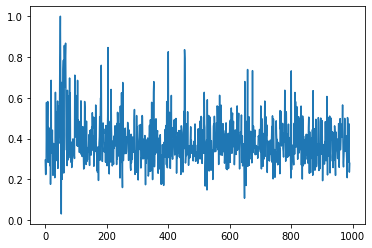

In [29]:
import matplotlib.pyplot as plt
plt.plot(rho_list)

In [30]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)
horizon = 5

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = True)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()

print(f"MSE On test : {mse_pred:.4f}")

MSE On test : 0.0107


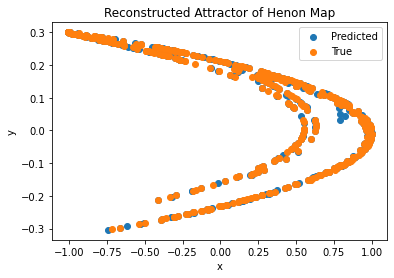

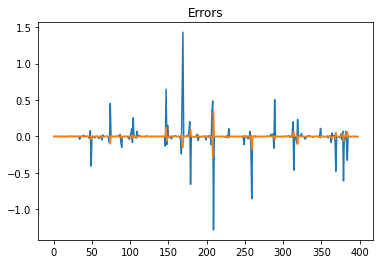

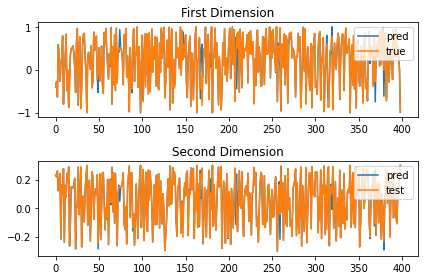

In [31]:
import matplotlib.pyplot as plt
plt.scatter(Y_pred[:,0].detach(),Y_pred[:,1].detach(), label = "Predicted")
plt.scatter(Y_test[:,0],Y_test[:,1], label = "True")
plt.title("Reconstructed Attractor of Henon Map")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

plt.figure()
plt.plot(Y_pred[:,0].detach()-Y_test[:,0])
plt.plot(Y_pred[:,1].detach()-Y_test[:,1])
plt.title("Errors")
plt.show()

fig, ax = plt.subplots(2,1)
ax[0].plot(Y_pred[:,0].detach(),label = "pred")
ax[0].plot(Y_test[:,0], label = "true")
ax[0].set_title("First Dimension")
ax[0].legend(loc = "upper right")

ax[1].plot(Y_pred[:,1].detach(),label = "pred")
ax[1].plot(Y_test[:,1], label = "test")
ax[1].set_title("Second Dimension")
ax[1].legend(loc = "upper right")
fig.tight_layout()

# Enforcing the semi-group property

This is outdated.

In [2]:
max_delay = 3
N_points = 1000
dt = 0.1

delays = np.random.randint(max_delay,size=N_points-1)+1
indices = np.concatenate((np.zeros(1),np.cumsum(delays))).astype(int)
delays = np.concatenate((delays,np.zeros(1))).astype(int)

max_idx = indices[-1]
T = np.ceil(max_idx/dt)
# generate dataset
Data = datagen.Henon(T=T, dt=dt,N_sims=1,a=1.4,b=0.3)[0]
#train test split

observed_data = Data[indices]

train_data = observed_data[:600,:].T
test_data = observed_data[600:,:].T
delays_train = delays[:600]
delays_test = delays[600:]

# Some constants
nparameters=24
delay = 1
regu_lambda = 0.00001

# Get scaling factor
normalize=np.amax(train_data[:,:])

X_train, Y_train = datagen.prepare_data_fast(train_data,delay,normalize, delays_train)
X_test, Y_test = datagen.prepare_data_fast(test_data,delay,normalize, delays_test)

model = kernel_flow.KernelFlows("anl3", nparameters = nparameters, regu_lambda = regu_lambda, dim = 2, metric = "rho_ratio", batch_size = 100)

model.set_training_data(torch.Tensor(X_train).double(),torch.Tensor(Y_train).double())

In [3]:
model.prepare_semi_group_simple(n_z = 50, delays_train = torch.Tensor(delays_train))

In [4]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
verbose = False
#print(model.z_tensor)
params_list = []
rho_list = []
for i in tqdm.tqdm(range(1000)):
    optimizer.zero_grad()
    rho = model.forward()
    if rho>=0 and rho<=1:
        rho.backward()
        optimizer.step()
        params_list.append(model.kernel_params.clone())
        rho_list.append(rho)
        if verbose:
            print(rho)
#print(model.z_tensor)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:12<00:00, 76.93it/s]


In [6]:
model.compute_kernel_and_inverse(regu_lambda = regu_lambda)

horizon = 1

Y_pred = model.predict_ahead(X_test,horizon=horizon, delay = delay, delta_t_mode = False)

mse_pred = (Y_pred.detach()-Y_test).pow(2).mean()

print(f"MSE On test : {mse_pred:.4f}")

MSE On test : 0.0002


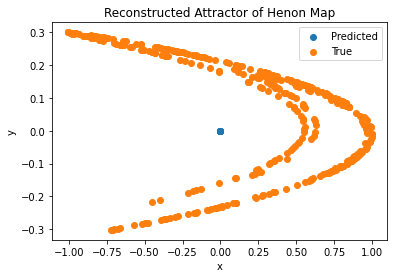

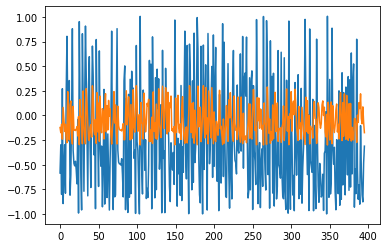

In [65]:
import matplotlib.pyplot as plt
plt.scatter(Y_pred[:,0].detach(),Y_pred[:,1].detach(), label = "Predicted")
plt.scatter(Y_test[:,0],Y_test[:,1], label = "True")
plt.title("Reconstructed Attractor of Henon Map")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()
